<a href="https://colab.research.google.com/github/Ferrariagustinpablo/DataScienceprojects/blob/main/1C_Part_1_Exploring_and_analyzing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing and connecting to Kaggle

In [34]:
# Importing common used libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
!pip install dc_stat_think
import dc_stat_think as dcst
import statsmodels.api as sm

In [35]:
# Style of plots
plt.style.use('ggplot')

In [37]:
# Choose a the kaggle.json file downloaded from Kaggle.
from google.colab import files
files.upload()

# Create a kaggle file and put kaggle.json in it.
!mkdir -p ~/kaggle
!cp kaggle.json ~/.kaggle/

# Hide API account key.
!chmod 600 /root/.kaggle/kaggle.json

# kaggle datasets 
!kaggle competitions download -c competitive-data-science-predict-future-sales

Saving kaggle.json to kaggle (4).json
shops.csv: Skipping, found more recently modified local copy (use --force to force download)
items.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
item_categories.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sales_train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [38]:
# Sales train dataset
sales = pd.read_csv('/content/sales_train.csv.zip')

# Control Values and value types

Next code describes values types are correct and there aren't any NaN values.

Dataset is big with almost 3 million rows (As we can see each rows represent a transaction)

In [39]:
print("----------Top-5- Record----------")
display(sales.head(5))
print("-----------Information-----------")
print(sales.info())
print("-----------Data Types-----------")
print(sales.dtypes)
print("----------Null values-----------")
print(sales.isna().sum())
print("----------Shape of Data----------")
print(sales.shape)

----------Top-5- Record----------


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.000,1.000
1,03.01.2013,0,25,2552,899.000,1.000
2,05.01.2013,0,25,2552,899.000,-1.000
3,06.01.2013,0,25,2554,1709.050,1.000
4,15.01.2013,0,25,2555,1099.000,1.000


-----------Information-----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB
None
-----------Data Types-----------
date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object
----------Null values-----------
date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64
----------Shape of Data----------
(2935849, 6)


## Control values:

In [40]:
# Display float not Scientific notation:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Describe
sales.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2935849.000,2935849.000,2935849.000,2935849.000,2935849.000
mean,14.570,33.002,10197.227,890.853,1.243
std,9.423,16.227,6324.297,1729.800,2.619
min,0.000,0.000,0.000,-1.000,-22.000
25%,7.000,22.000,4476.000,249.000,1.000
50%,14.000,31.000,9343.000,399.000,1.000
75%,23.000,47.000,15684.000,999.000,1.000
max,33.000,59.000,22169.000,307980.000,2169.000


## Control values on dates

parse_dates in pandas does not classify correctly, therefore:

In [41]:
# to_datetime or strptime
sales.date = sales.date.apply(lambda x:dt.datetime.strptime(x, '%d.%m.%Y'))

# Sort date feature so I can plot by dates.
sales = sales.sort_values(by='date')
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
49800,2013-01-01,0,18,5823,2500.000,1.000
29784,2013-01-01,0,27,5573,849.000,1.000
35476,2013-01-01,0,7,1006,399.000,1.000
8330,2013-01-01,0,19,17707,899.000,1.000
57384,2013-01-01,0,14,19548,149.000,1.000


In [42]:
sales_dtmin = sales.date.min()
sales_dtmax = sales.date.max()

print('Dataset goes from {} to {}'.format(sales_dtmin,sales_dtmax))

Dataset goes from 2013-01-01 00:00:00 to 2015-10-31 00:00:00


## Control values on item_cnt_day 

It seems there are some outliers on item_cnt_day:

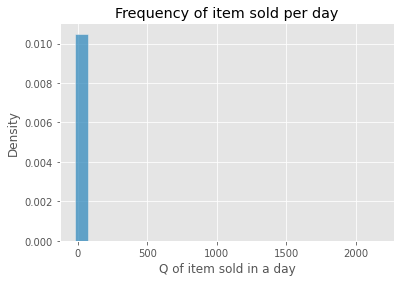

In [43]:
# Plot item_cnt_day Histplot:
sns.histplot(sales.item_cnt_day, stat='density', label='count')
plt.title('Frequency of item sold per day')
plt.xlabel('Q of item sold in a day')
plt.show()

In [44]:
# Previous bar chart depicts it might be count of 2000 items sold in a day.
rare_q = sales[sales.item_cnt_day>600]
display(rare_q)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2326930,2015-01-15,24,12,20949,4.000,1000.000
2608040,2015-04-14,27,12,3731,1904.548,624.000
2864235,2015-09-30,32,12,9248,1692.526,669.000
2851091,2015-09-30,32,55,9249,1702.826,637.000
2909818,2015-10-28,33,12,11373,0.909,2169.000


item_cnt_day feature has negative numbers. 
This represents some products have been returned.

Let's see how many times this happened.

In [45]:
# Check lower boundary of item count.
min_cnt_day = sales.item_cnt_day.min()
rare_q_low = sales[sales.item_cnt_day<0]

print('There are {} rows with negative item_cnt_day from {} to -1.'.format(rare_q_low.shape[0], min_cnt_day))

There are 7356 rows with negative item_cnt_day from -22.0 to -1.


## Control values on item_price

In describe we see there are some item_price as values -1.

Let's see how many observations we have:

In [46]:
# Check lower boundary:
print(sales.item_price.min())

# Seems there are negative prices. Only one row.
display(sales[sales.item_price<0])

-1.0


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,2013-05-15,4,32,2973,-1.000,1.000


There is only one so we would just drop it.

In [47]:
# Drop observation
sales = sales.drop(sales[sales.item_price<0].index, axis=0)

In [48]:
# The .describe method showed an item value of $307980.000
# These are rare items that happend only three times of almost 3M transactions.

rare_item_prices = sales[sales.item_price>50000]
display(rare_item_prices)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
885138,2013-09-17,8,12,11365,59200.000,1.000
1163158,2013-12-13,11,12,6066,307980.000,1.000
1488135,2014-03-20,14,25,13199,50999.000,1.000


# Importing english dataset

I Download dataset that has been translated.

In [49]:
# kaggle datasets 
!kaggle datasets download -d kazimanil/predict-future-sales-supplementary

from zipfile import ZipFile
# Create a ZipFile Object and load sample.zip in it
with ZipFile('/content/predict-future-sales-supplementary.zip', 'r') as zipObj:
   # Unzip
   zipObj.extractall()

# Read Dataset
item = pd.read_csv('/content/item_category.csv')

print('Dataset shape is: ', item.shape)
display(item.head())

predict-future-sales-supplementary.zip: Skipping, found more recently modified local copy (use --force to force download)
Dataset shape is:  (22170, 4)


,item_id,item_name_translated,item_cat1,item_cat2
0,5441,PC: Headset HyperX Cloud Core gaming stereo (K...,PC,Headsets / Headphones
1,16255,Headphones PHILIPS SBC HC8680,PC,Headsets / Headphones
2,16256,Headphones RITMIX RH-120,PC,Headsets / Headphones
3,16257,Headphones RITMIX RH-124 Black,PC,Headsets / Headphones
4,5606,PS2: Memory Card 8 MB Black (Memory Card 8Mb -...,Accessories,PS2


## Complete dataset

In [50]:
# Left merge on item_id. Dataset sales with item
df = pd.merge(sales, item, on='item_id', how='left')
df.shape

(2935848, 9)

In [51]:
display(df.isnull().sum())
df = df.fillna("Other")           
display(df.isnull().sum())

date                        0
date_block_num              0
shop_id                     0
item_id                     0
item_price                  0
item_cnt_day                0
item_name_translated        0
item_cat1                   0
item_cat2               30403
dtype: int64

date                    0
date_block_num          0
shop_id                 0
item_id                 0
item_price              0
item_cnt_day            0
item_name_translated    0
item_cat1               0
item_cat2               0
dtype: int64

# Create some needed features: Sales, year and year/month

In [248]:
df['sales'] = df['item_price'] * df['item_cnt_day']
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['year/month'] =  df['date'].dt.strftime('%Y %m')
df.head()

KeyError: ignored

In [54]:
# Let's put date feature on index so I can plot.
df = df.set_index('date')
# Display head
df.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name_translated,item_cat1,item_cat2,sales,year,year/month
date,,,,,,,,,,,
2013-01-01,0,18,5823,2500.000,1.000,Playstation Store replenishment of wallet: Pay...,Payment cards,PSN,2500.000,2013,2013 01
2013-01-01,0,27,5573,849.000,1.000,PS Move Motion Controller Charger (Charging st...,Accessories,PS3,849.000,2013,2013 01
2013-01-01,0,7,1006,399.000,1.000,3D Crystal Puzzle Дельфин XL,Gifts,Development,399.000,2013,2013 01
2013-01-01,0,19,17707,899.000,1.000,Sport holiday (Essentials) (only for PS Move) ...,Games,PS3,899.000,2013,2013 01
2013-01-01,0,14,19548,149.000,1.000,SUCH DIFFERENT TWINS (region),Cinema,DVD,149.000,2013,2013 01


# Analyzing sales

## Monthly Sales during the period

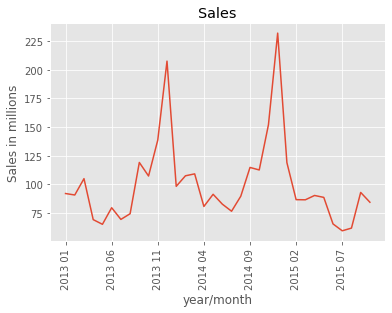

In [55]:
# Display float not Scientific notation:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# We want sales grouped by year/month
sales_grouped_ym = df.groupby('year/month').sum()['sales']/1000000

# Plot sales
sales_grouped_ym.plot(kind='line')
plt.title('Sales')
plt.xticks(rotation=90)
plt.ylabel('Sales in millions')
plt.show()

Sells are really seasonal. November and December are the most important months in sales.

Christmas and New year might be the most important events in the year. 

In [56]:
important_months = sales_grouped_ym.sort_values(ascending=False).head(4)
important_months

year/month
2014 12   232.025
2013 12   207.572
2014 11   152.038
2013 11   138.665
Name: sales, dtype: float64

In [57]:
# 2013
nov_dec_sales_2013 = important_months[['2013 11','2013 12']].sum()
pct_2013 = nov_dec_sales_2013 / (df[df.year == 2013]['sales'].sum()/1000000)

# 2014
nov_dec_sales_2014 = important_months[['2014 11','2014 12']].sum()
pct_2014 = nov_dec_sales_2014 / (df[df.year == 2014]['sales'].sum()/1000000)

print("November and December represents {:.2f}% in 2013 and {:.2f}% in 2014".format(pct_2013, pct_2014))

November and December represents 0.28% in 2013 and 0.29% in 2014


Around 30% of all year sales happens on November and December.

## Checking seasonality with statmodel SM

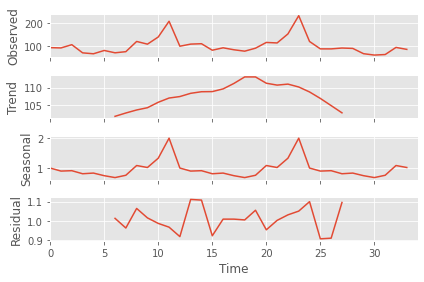

In [199]:
# multiplicative
res = sm.tsa.seasonal_decompose(sales_grouped_ym.values,freq=12,model="multiplicative")
fig = res.plot()
fig.show()

## What are the categories that sells more?

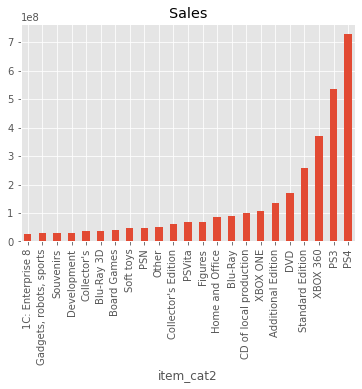

In [58]:
df_cat2_sales = df.groupby('item_cat2').sum().sales.sort_values()
# Plot sales
df_cat2_sales[df_cat2_sales>25000000].plot(kind='bar')
plt.title('Sales')
plt.xticks(rotation=90)
plt.show()

Most common categories are PS4, PS3, XBOX and 'Standard Edition'. 

This doesn't give much information if I where working in 1C. 'Standard Edition' values requires to be mapped again.

In [59]:
# check different cat1 in every 'Standard Edition' cat2.
df[df.item_cat2 == 'Standard Edition']['item_cat1'].unique()

array(['PC Games'], dtype=object)

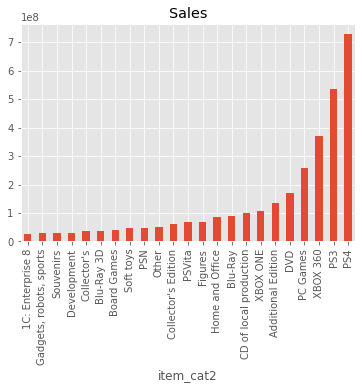

In [60]:
df.item_cat2 = df.item_cat2.str.replace('Standard Edition', 'PC Games')

df_cat2_sales = df.groupby('item_cat2').sum().sales.sort_values()
# Plot sales again
df_cat2_sales[df_cat2_sales>25000000].plot(kind='bar')
plt.title('Sales')
plt.xticks(rotation=90)
plt.show()

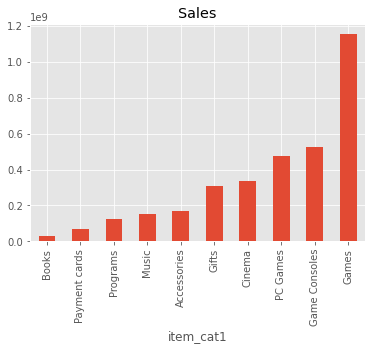

In [62]:
df_cat1_sales = df.groupby('item_cat1').sum().sales.sort_values()
# Plot sales again
df_cat1_sales[df_cat1_sales>25000000].plot(kind='bar')
plt.title('Sales')
plt.xticks(rotation=90)
plt.show()

## What % of sales top 4 categories represent?

In [63]:
sum_sales_4cat = df_cat2_sales.sort_values(ascending=False).head(4).sum()
total_sales_df = df['sales'].sum()
pct_top4cat = sum_sales_4cat/total_sales_df

print('Total sales of those top 4 categories in all dataset time period is {:.2f}%'.format(pct_top4cat))

Total sales of those top 4 categories in all dataset time period is 0.56%


56% of all sales in dataset has been explained by PC Games, Xbox360, PS3 and PS4.

This shows high dependency on those Brands.

## What percentage of total sales are Play Station products?

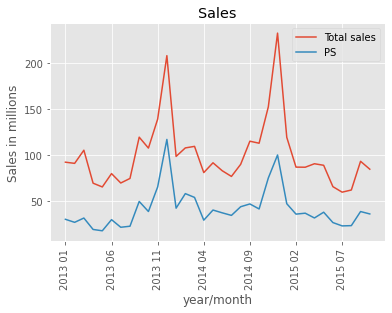

In [64]:
# Calculate year/month sales of trnsactions that are only Play Station
df_ps_grouped = df[df['item_cat2'].str.contains("PS")].groupby('year/month').sum()['sales']/1000000

# Plot sales and PS sales
sales_grouped_ym.plot(kind='line', label='Total sales')
df_ps_grouped.plot(kind='line', label='PS')
plt.title('Sales')
plt.xticks(rotation=90)
plt.ylabel('Sales in millions')
plt.legend()
plt.show()

In [65]:
sum_play = df_ps_grouped.sum()*1000000
pct_playstation = sum_play/total_sales_df

print('Total sales of PS in all dataset time period is {:.2f}%'.format(pct_playstation))

Total sales of PS in all dataset time period is 0.41%


Play station products goes around 40% of total sales. This means 1C has a dependency in PS products quality, design and demand.


# Analyzing shops

## How many shops are there? Are all open and selling? Some new ones?
 

In [66]:
unique_shops = df.shop_id.unique()
print('There are {} shops in the dataset'.format(len(unique_shops)))

There are 60 shops in the dataset


## Pivot Table

In [67]:
# I create a pivot table where 
sales_by_shop_id = df.pivot_table(index=['shop_id'],values=['item_cnt_day'], 
                                        columns='date_block_num', aggfunc=np.sum, fill_value=0).reset_index()
                                        
sales_by_shop_id.columns = sales_by_shop_id.columns.droplevel().map(str)
sales_by_shop_id = sales_by_shop_id.reset_index(drop=True).rename_axis(None, axis=1)
sales_by_shop_id.columns.values[0] = 'shop_id'

sales_by_shop_id.head()

,shop_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
0,0,5578,6127,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,2947,3364,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,1146,488,753,583,553,832,807,875,945,795,862,1322,890,911,990,791,910,957,838,956,920,945,1192,1921,987,907,762,859,843,804,785,942,822,727
3,3,767,798,959,647,710,784,721,890,1026,793,970,1134,968,873,1105,685,776,828,758,902,960,805,1063,1275,977,738,741,740,731,672,535,666,745,613
4,4,2114,2025,2060,285,1211,1464,1378,1713,1536,1482,1486,2248,1430,1299,1246,1155,1324,1213,1091,1387,1090,1180,1371,2071,1188,980,978,899,893,793,842,947,732,831


### New shops and other that no longer exists.

In [68]:
for i in range(6,34):
    print('Not exists in month',i,sales_by_shop_id['shop_id'][sales_by_shop_id.loc[:,'0':str(i)].sum(axis=1)==0].values)

for i in range(6,34):
    print('Shop is outdated for month',i,sales_by_shop_id['shop_id'][sales_by_shop_id.loc[:,str(i):].sum(axis=1)==0].values)

Not exists in month 6 [ 9 11 20 33 34 36 39 40 48 49]
Not exists in month 7 [ 9 11 20 33 34 36 39 40 48 49]
Not exists in month 8 [ 9 11 20 33 34 36 39 40 48 49]
Not exists in month 9 [11 20 33 34 36 39 40 48 49]
Not exists in month 10 [11 20 33 34 36 39 40 48 49]
Not exists in month 11 [11 20 33 34 36 39 40 48]
Not exists in month 12 [11 20 33 34 36 39 40 48]
Not exists in month 13 [11 20 33 34 36 39 40 48]
Not exists in month 14 [11 20 33 34 36 48]
Not exists in month 15 [11 20 33 34 36]
Not exists in month 16 [11 20 33 34 36]
Not exists in month 17 [11 20 33 34 36]
Not exists in month 18 [11 20 33 36]
Not exists in month 19 [11 20 36]
Not exists in month 20 [11 20 36]
Not exists in month 21 [11 36]
Not exists in month 22 [11 36]
Not exists in month 23 [11 36]
Not exists in month 24 [11 36]
Not exists in month 25 [36]
Not exists in month 26 [36]
Not exists in month 27 [36]
Not exists in month 28 [36]
Not exists in month 29 [36]
Not exists in month 30 [36]
Not exists in month 31 [36]


### How many shops where open in November and December 2015?

In [69]:
# Months 32 and 33 shouldn't be 0:
q_shops_running = sales_by_shop_id[sales_by_shop_id.loc[:,'32':].sum(axis=1)!=0].shape[0]

print('There are {} shops up and running in November and December 2015'.format(q_shops_running))

There are 46 shops up and running in November and December 2015


### Shops that were created after 2014 01 01

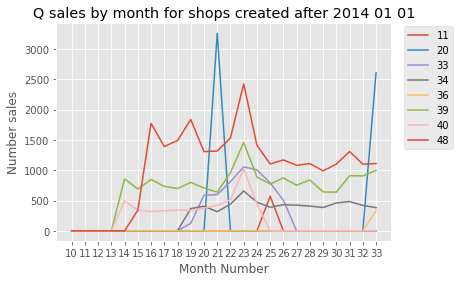

In [70]:
sales_by_shop_id.set_index('shop_id', inplace=True)

# Plot shops created after 2014 01 01
for i in range(len(sales_by_shop_id.index+1)):
  if sales_by_shop_id.iloc[i,:12].sum() == 0:
    sns.lineplot(y=sales_by_shop_id.iloc[i].values[10:], x=sales_by_shop_id.columns[10:], label=i)
    plt.ylabel('Number sales')
    plt.xlabel('Month Number')
    plt.title('Q sales by month for shops created after 2014 01 01')
# Plot legend outside figure
plt.legend(bbox_to_anchor=(1.2, 1.01))
plt.show()

## Evolution of open shops

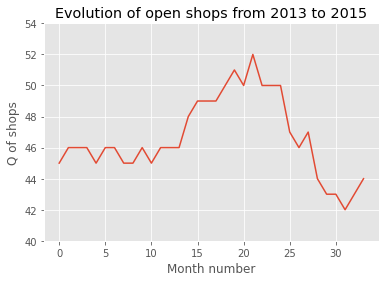

In [71]:
n_shops = sales_by_shop_id.apply(lambda x: x.map({0:0})).fillna(1).sum(axis=0)

# Plot sales and PS sales
n_shops.plot(kind='line')
plt.title('Evolution of open shops from 2013 to 2015')
plt.yticks(np.arange(40,56,2))
plt.ylabel('Q of shops')
plt.xlabel('Month number')
plt.show()

## Combined time series plot of number of shops and total sales 

Plot with combined y axis

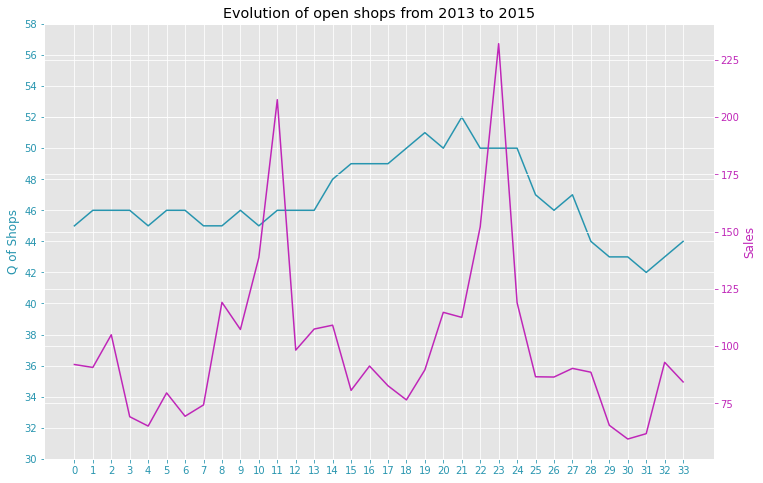

In [72]:
# We want sales grouped by date_block_num
sales_grouped_date = df.groupby('date_block_num').sum()['sales']/1000000

# Initalize a Figure and Axes
fig, ax = plt.subplots()
fig.set_size_inches([12,8])
ax.plot(n_shops.index, n_shops.values, color='#2795AF')
# Create a twin Axes that shares the x-axis
ax2 = ax.twinx()
ax2.plot(sales_grouped_date.index, sales_grouped_date.values, color='#BF26B8')
# Set y labels and colors
ax.set_ylabel('Q of Shops', color='#2795AF')
ax2.set_ylabel('Sales', color='#BF26B8')
ax.set_yticks(np.arange(30,60,2))
ax.tick_params(colors='#2795AF')
ax2.tick_params(colors='#BF26B8')
plt.title('Evolution of open shops from 2013 to 2015')
plt.xlabel('Month number')
plt.show()


I see that in Dec 2013 there were 45 shops and revenue of around 205 million. In 2014 the company was creating more shops. With 5 more, the organization reached more than 230 million. But that expansions ceased at that time were they lowered it's presence to 42/44 shops in less than a year.

### Non-permanent shops

Next line graph depicts sales (in quantity) of shops that are not permanent.

More than 'shops' they might represent sales in fairs or other ad-hoc places.

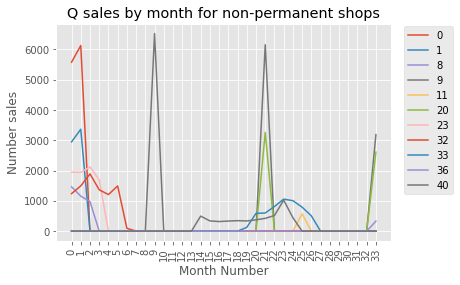

In [73]:
for i in range(len(sales_by_shop_id.index+1)):
  month_no_sales = 0
  for value in sales_by_shop_id.iloc[i,:].values:
    if value == 0:
      month_no_sales += 1
  # Filter for most of the time without any sale.
  if month_no_sales >= 20:
    sns.lineplot(y=sales_by_shop_id.iloc[i].values, x=sales_by_shop_id.columns, label=i)
    plt.xticks(rotation=90)
    plt.ylabel('Number sales')
    plt.xlabel('Month Number')
    plt.title('Q sales by month for non-permanent shops')
# Plot legend outside figure
plt.legend(bbox_to_anchor=(1.2, 1.01))
plt.show()



There are clearly 3 shops that are non-permanent. 

Ids are 9,11,20. Let's check their sales.

In [74]:
sales_by_shop_id.loc[[9,11,20]] 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
shop_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9,0,0,0,0,0,0,0,0,0,6526,0,0,0,0,0,0,0,0,0,0,0,6155,0,0,0,0,0,-1,0,0,0,0,0,3186
11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,572,0,0,0,0,0,0,0,0
20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3261,0,0,0,0,0,0,0,0,0,0,0,2611


#### What type of items are sold in these 'shops'

In [75]:
# Category of most important sales of non-pemanent shops:
df_nonperm_shops = df[df.shop_id.isin([9,11,20])]
nonperm_5ban = df_nonperm_shops.groupby('item_cat1').sum()['sales'].sort_values(ascending=False).head(5)
nonperm_most_imp_cat1 = nonperm_5ban / df_nonperm_shops.sales.sum()
display(nonperm_most_imp_cat1)

item_cat1
Gifts           0.580
Games           0.178
PC Games        0.137
Game Consoles   0.034
Books           0.034
Name: sales, dtype: float64

In [76]:
# Category of most important sales of all shops of the firms:
df_5ban = df_cat1_sales.sort_values(ascending=False).head(5)
df_most_imp_cat1 = df_5ban / df_cat1_sales.sum()
display(df_most_imp_cat1)

item_cat1
Games           0.339
Game Consoles   0.155
PC Games        0.141
Cinema          0.099
Gifts           0.091
Name: sales, dtype: float64

### Difference between shops

Last 2 tables show that non-perm shops has 58% of it's sales in Gifts category whilst it represents 9% of total sales company.

Secondly, non-perm shops has irrelevant Game Consoles sale with 3.4% of sales, in contrast to other normal shops that has 15.5%.

Thirdly, there aren't any relevant Cinema sales but this category explains 9% of total C1 revenue.

In conclusion non-perm shops ids: 9,11,20, are really different from the average of 1C shops.


## What are the most important shops in sales? Where are they located? 80/20 rule?

As explained in Kaggle, item_price feature represents current price of an item. 

This price is in homogeneous currency so It would be ready for analyzing.

In [77]:
# Let's create a new series with shop_id as index and sales
df_id_sales = df.groupby('shop_id').sum().sales.sort_values()
df_id_sales.head()

shop_id
36    377714.000
11    521655.140
8    2349358.000
1    3238207.000
40   4293586.850
Name: sales, dtype: float64

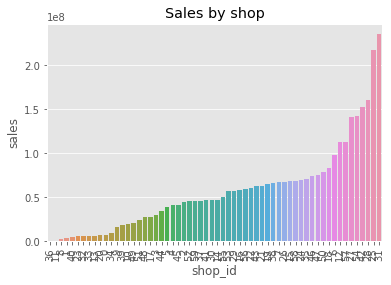

In [78]:
df_id_sales_to_plot = df_id_sales.reset_index()

# Create a bar plot of interest in math, separated by gender
sns.barplot(x='shop_id', y="sales",
            data=df_id_sales_to_plot, order=df_id_sales_to_plot.sort_values(by='sales').shop_id)

# Show plot
plt.title('Sales by shop')
plt.xticks(rotation=90)
plt.show()

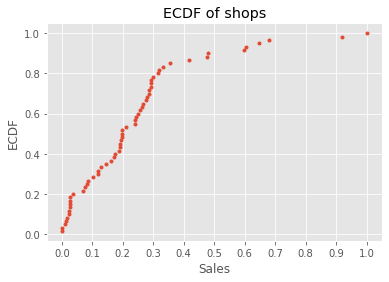

In [79]:
# Calculate empirical cumulative function
a,b = dcst.ecdf(df_id_sales)

# Make max cumulative sale == 1
a = a/a.max()

# Make the plot
plt.plot(a,b, marker='.', linestyle='none')
plt.xlabel('Sales')
plt.ylabel('ECDF')
plt.title('ECDF of shops')
plt.xticks(np.linspace(0,1,11))
plt.show()

### 20% of the shops explains ?% of sales?

In [80]:
# Visually I can see that 80% of less succesfull shops explains 30% of sales.
# Making exact calculations:

result = np.array(np.where(b >= 0.8)).reshape(-1)
print('{:.2f}% of shops makes {:.2f}% of total sales'.format(b[result[0]]*100, a[result[0]]*100))

# Then, 20% of shops make sales of:
print('{:.2f}% of shops makes {:.2f}% of total sales'.format(-b[result[0]]*100+100, -a[result[0]]*100+100))

80.00% of shops makes 31.54% of total sales
20.00% of shops makes 68.46% of total sales


We can say it has an 70/20 paretto rule.


### Where are the most important shops located?

In [81]:
df_id_sales.tail(9).index

# Import shops dataset
shops = pd.read_csv('/content/shops-translated.csv')

In [82]:
shops[shops.shop_id.isin(df_id_sales.tail(9).index)]

,shop_id,City,Type,Name
6,6,Voronezh,Shop,"(Plekhanovskaya, 13)"
12,12,Web,Web,Online Shop Emergency
25,25,Moscow,TRC,Atrium
27,27,Moscow,TC,MEGA Belaya Dacha II
28,28,Moscow,TC,"MEGA Teply Stan II"""
31,31,Moscow,TC,Семеновский
42,42,SanktPetersburg,TC,Nevsky Center
54,54,Khimki,TC,Mega
57,57,Yakutsk,Shop,"Ordzhonikidze, 56"


# Analyzing items

## Is the company adding new products to sale?

In [84]:
df.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name_translated,item_cat1,item_cat2,sales,year,year/month
date,,,,,,,,,,,
2013-01-01,0,18,5823,2500.000,1.000,Playstation Store replenishment of wallet: Pay...,Payment cards,PSN,2500.000,2013,2013 01
2013-01-01,0,27,5573,849.000,1.000,PS Move Motion Controller Charger (Charging st...,Accessories,PS3,849.000,2013,2013 01
2013-01-01,0,7,1006,399.000,1.000,3D Crystal Puzzle Дельфин XL,Gifts,Development,399.000,2013,2013 01
2013-01-01,0,19,17707,899.000,1.000,Sport holiday (Essentials) (only for PS Move) ...,Games,PS3,899.000,2013,2013 01
2013-01-01,0,14,19548,149.000,1.000,SUCH DIFFERENT TWINS (region),Cinema,DVD,149.000,2013,2013 01


### Groupby with .transform

In [91]:
# creating a first sale day feature.

df['first_sale_day'] = df.index.dayofyear 
df['first_sale_day'] = df['first_sale_day'] + 365 * (df.index.year - 2013)
df['first_sale_day'] = df.groupby('item_id')['first_sale_day'].transform('min').astype('int16')
df['first_sale_day']

date
2013-01-01       1
2013-01-01       1
2013-01-01       1
2013-01-01       1
2013-01-01       1
              ... 
2015-10-31     661
2015-10-31     225
2015-10-31     190
2015-10-31     868
2015-10-31    1019
Name: first_sale_day, Length: 2935848, dtype: int16

### What percentage of items where released in 2014/5?

In [110]:
# Check how many new products were in 2014 and 2015.
released_2014 = df[(df.first_sale_day>365) & (df.first_sale_day<365*2)]
print('There where {0} new products on sale in 2014. This means {1:.2f}% of all products available.'.format(len(released_2014.item_id.unique()), len(released_2014.item_id.unique())/len(df.item_id.unique())*100))

released_2015 = df[df.first_sale_day>365*2]
print('There where {0} new products on sale in 2015. This means {1:.2f}% of all products available.'.format(len(released_2015.item_id.unique()), len(released_2015.item_id.unique())/len(df.item_id.unique())*100))

There where 4064 new products on sale in 2014. This means 18.64% of all products available.
There where 2760 new products on sale in 2015. This means 12.66% of all products available.


### Does new products sells more than older ones?

Text(0.5, 1.08, 'Sales for items released in 2014 vs old ones')

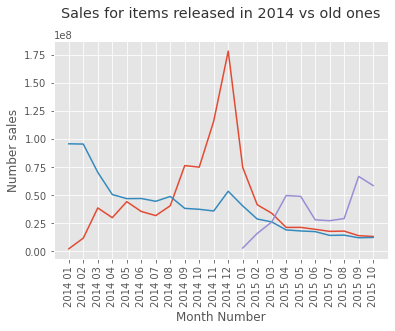

In [146]:
# With dataset of products released in 2014 I groupby by year and month and plot sale:
new_2014 = released_2014.groupby('year/month').sum()['sales'].reset_index()
new_2015 = released_2015.groupby('year/month').sum()['sales'].reset_index()
not_released_2014 = df[(df.first_sale_day<365) & (df['year/month'].isin(released_2014['year/month']))].groupby('year/month').sum()['sales'].reset_index()

# Plot 
sns.lineplot(y='sales', x='year/month', data=new_2014)
sns.lineplot(y='sales', x='year/month', data=not_released_2014)
sns.lineplot(y='sales', x='year/month', data=new_2015)
plt.xticks(rotation=90)
plt.ylabel('Number sales')
plt.xlabel('Month Number')
plt.title('Sales for items released in 2014 vs old ones', y=1.08, alpha=0.8)

Visually it is really clear that new items outperform other released in past years.

This company sells products that may be tied to the 'latest', the 'new', the 'trend'. 

So new released products are really important in the sales of this company. It rellies on latest products to keep sales up. This could be a metric to follow periodicly for predicting future sales and a great metric for company performance. 

I'll undoubtedly going to use it in machine learning prediction. Maybe creating a feature released_this_year 1 if yes, 0 if it doesn't.

## Visualizing Product lifespan after first purchase.

For this feature I am going to calculate 'days old'. It's birthday is the day of the first made sale of the item ('first_sale_day')

In [ ]:
df['first_sale_day'] = df.index.dayofyear 
df['first_sale_day'] = df['first_sale_day'] + 365 * (df.index.year - 2013)

In [216]:
df['day_number'] = df.index.dayofyear
df['day_number'] = df['day_number'] + 365 * (df.index.year - 2013)
df['item_days_old'] = df['day_number'] - df['first_sale_day']
df['item_days_old'].tail(10)

date
2015-10-31     982
2015-10-31       7
2015-10-31     955
2015-10-31    1033
2015-10-31     806
2015-10-31     373
2015-10-31     809
2015-10-31     844
2015-10-31     166
2015-10-31      15
Name: item_days_old, dtype: int64

In [218]:
product_age_sales.reset_index()

,item_days_old,sales
0,0,5154.842
1,1,4106.091
2,2,2692.025
3,3,2235.569
4,4,1953.075
...,...,...
1029,1029,808.302
1030,1030,768.415
1031,1031,822.237
1032,1032,972.265


   item_days_old         sales
0              0 209503104.780
1              1 120912054.940
2              2  80055430.730
3              3  63677957.160
4              4  52867781.110
5              5  41828220.430
6              6  36382482.750
7              7  37416914.350
8              8  34182373.030
9              9  30734740.780


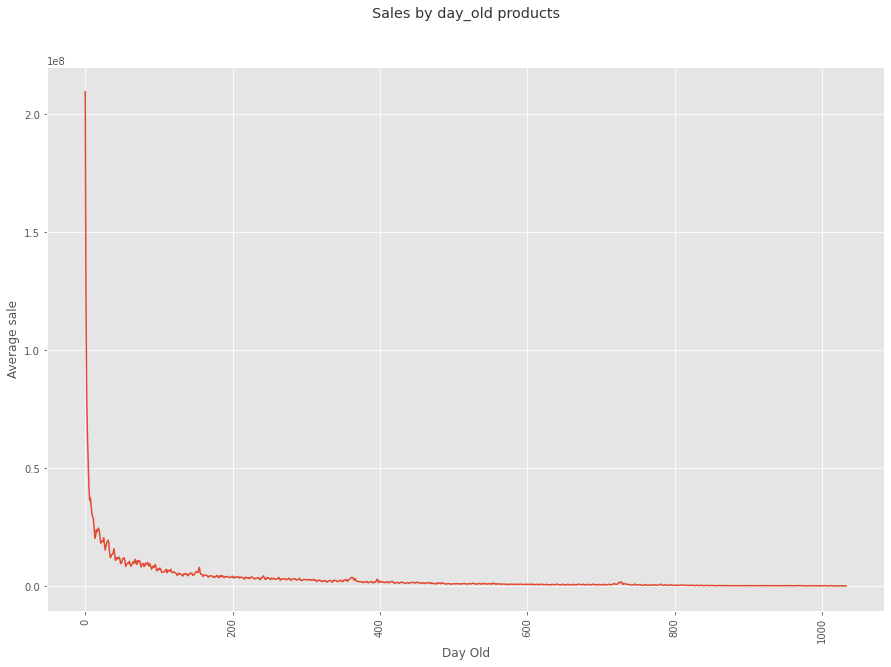

In [241]:
# Create the table with item_days_old	and average sales
product_age_sales = df.groupby('item_days_old').sum()['sales'].reset_index()
print(product_age_sales.head(10))

# Plot 
# Initalize a Figure and Axes
fig, ax = plt.subplots()
fig.set_size_inches([15,10])
sns.lineplot(ax=ax, y='sales', x='item_days_old', data=product_age_sales)
plt.xticks(rotation=90)
#ax.set_yscale('log') # If I want to see it logarithmic
plt.ylabel('Average sale')
plt.xlabel('Day Old')
plt.title('Sales by day_old products', y=1.08, alpha=0.8)
plt.show()

## Does sales changes by day of the week?

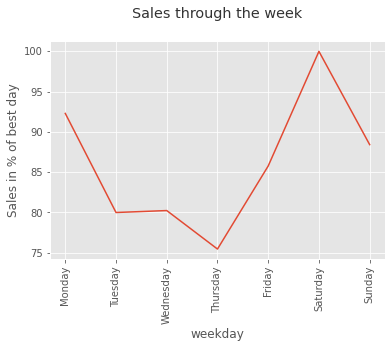

In [203]:
df['weekday'] = df.index.day_name()

weekday_plot = df.groupby('weekday').mean()['sales']
weekday_plot = weekday_plot / weekday_plot.max() * 100

# Plot sales through the week as % of best the ay
weekday_plot.plot(kind='line')
plt.title('Sales through the week', y=1.08, alpha=0.8)
plt.xticks(np.arange(0,7,1), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=90)
plt.ylabel('Sales in % of best day')
plt.show()

Saturdays are the busiest days.